## prep

In [1]:
from stk_actor.training_strategies.behavioral_cloning import get_flat_env_stats_for_bhc
from stk_actor.training_strategies.behavioral_cloning import merge_buffers_for_supervision
from stk_actor.agent import UnifiedSACPolicy
import random
from torch.optim import AdamW
import torch
import numpy as np

device = 'mps'

In [2]:

class PolicyWrapper(torch.nn.Module):
    def __init__(self, policy_stb, dropout):
        super().__init__()
        self.shared = policy_stb
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self, x):
        x = self.shared.features_extractor(x)
        x = self.shared.mlp_extractor.policy_net(x)
        x = self.dropout(x)
        x = self.shared.action_net(x)
        return x


def get_policy(state_items=5, state_karts=5, state_paths=5):

    observation_space, action_space, observation_dim, action_dims = get_flat_env_stats_for_bhc(
        state_items=state_items, state_karts=state_karts, state_paths=state_paths,
    )
    
    policy_stb = UnifiedSACPolicy(
        observation_space=observation_space,
        action_dims=action_dims,
        net_arch=[1024,1024,1024],
        activation_fn=torch.nn.Tanh,
    ).shared

    device = 'mps'
    policy = PolicyWrapper(
        policy_stb, dropout=0,
    ).to(device)

    return policy, observation_space, action_space, observation_dim, action_dims
    


In [3]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

import tqdm

def train_policy(
    policy, observations, actions, track, action_dims, indices,
    batch_size=1024 * 16, num_epochs=1000, lr=2e-3, device='mps', normalize=True
):
    # Normalization
    mean = observations.mean(dim=0).to(device)
    std = observations.std(dim=0).to(device)
    observations = observations.to(device)
    actions = actions.to(device)
    track = track.to(device)
    
    # Split data into training and test sets
    
    split = int(0.8 * len(indices))
    train_idx, test_idx = indices[:split], indices[split:]
    
    obs_train, obs_test = observations[train_idx], observations[test_idx]
    actions_train, actions_test = actions[:, train_idx], actions[:, test_idx]
    track_train, track_test = track[train_idx], track[test_idx]
    
    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    history = {
        'train_loss': [], 'test_loss': [],
        'train_accuracies': [], 'test_accuracies': [],
        'train_loss_per_action': [[] for _ in range(len(action_dims))],
        'test_loss_per_action': [[] for _ in range(len(action_dims))],
        'train_accuracies_per_action': [[] for _ in range(len(action_dims))],
        'test_accuracies_per_action': [[] for _ in range(len(action_dims))]
    }
    
    def get_batches(obs, acts, trk, batch_size):
        size = obs.shape[0]
        indices = np.arange(size)
        np.random.shuffle(indices)
        num_batches = int(np.ceil(size / batch_size))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, size)
            batch_indices = indices[start_idx:end_idx]
            yield obs[batch_indices], acts[:, batch_indices], trk[batch_indices]
    
    for epoch in tqdm.tqdm(list(range(num_epochs))):
        policy.train()
        total_loss, num_batches = 0, 0
        action_correct = [0] * len(action_dims)
        action_total = [0] * len(action_dims)
        action_losses = [0] * len(action_dims)
        
        for obs, acts, trk in get_batches(obs_train, actions_train, track_train, batch_size):
            obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
            if normalize:
                obs = (obs - mean) / (std + 1e-8)
                obs += torch.randn_like(obs) * 0.01
            acts = acts.permute(1, 0)
            
            outputs = policy(obs)
            optimizer.zero_grad()
            split_logits = torch.split(outputs, action_dims, dim=-1)
            
            losses = []
            for i in range(len(action_dims)):
                loss_i = criterion(split_logits[i], acts[:, i])
                losses.append(loss_i.mean())
                action_losses[i] += loss_i.mean().item()
                
                predicted = torch.argmax(split_logits[i], dim=1)
                correct = (predicted == acts[:, i]).sum().item()
                action_correct[i] += correct
                action_total[i] += acts.size(0)
            
            loss = sum(losses)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        train_accuracies = [correct / (total or 1) * 100 for correct, total in zip(action_correct, action_total)]
        train_losses = [l / num_batches for l in action_losses]
        
        # Evaluate on test set
        policy.eval()
        with torch.no_grad():
            test_loss, test_correct, test_total = 0, [0] * len(action_dims), [0] * len(action_dims)
            test_action_losses = [0] * len(action_dims)
            test_batches = list(get_batches(obs_test, actions_test, track_test, batch_size))
            
            for obs, acts, trk in test_batches:
                obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
                if normalize:
                    obs = (obs - mean) / (std + 1e-8)
                    obs += torch.randn_like(obs) * 0.01
                acts = acts.permute(1, 0)
                
                outputs = policy(obs)
                split_logits = torch.split(outputs, action_dims, dim=-1)
                
                batch_losses = [criterion(split_logits[i], acts[:, i]).mean().item() for i in range(len(action_dims))]
                for i in range(len(action_dims)):
                    test_action_losses[i] += batch_losses[i]
                    predicted = torch.argmax(split_logits[i], dim=1)
                    test_correct[i] += (predicted == acts[:, i]).sum().item()
                    test_total[i] += acts.size(0)
            
            test_loss = sum(test_action_losses) / len(test_batches)
            test_accuracies = [correct / (total or 1) * 100 for correct, total in zip(test_correct, test_total)]
            test_losses = [l / len(test_batches) for l in test_action_losses]
        
        history['train_loss'].append(avg_loss)
        history['test_loss'].append(test_loss)
        history['train_accuracies'].append(train_accuracies)
        history['test_accuracies'].append(test_accuracies)
        
        for i in range(len(action_dims)):
            history['train_loss_per_action'][i].append(train_losses[i])
            history['test_loss_per_action'][i].append(test_losses[i])
            history['train_accuracies_per_action'][i].append(train_accuracies[i])
            history['test_accuracies_per_action'][i].append(test_accuracies[i])
        
    return history

## flattened_num5

In [4]:
num_epochs = 500
start_step_id = 25

In [5]:
buffer_names = [
    'stk_actor/buffers/flattened_num5/all_tracks_buffer_steps_diff2', 
    'stk_actor/buffers/flattened_num5/all_tracks_buffer_steps_diff2x', 
    'stk_actor/buffers/flattened_num5/all_tracks_buffer_steps_diff2xx', 
    'stk_actor/buffers/flattened_num5/all_tracks_buffer_steps_diff2xxx'
]

observations, actions, track, size = merge_buffers_for_supervision(
    buffer_names=buffer_names,
    start_step_id=start_step_id,
)

indices = np.arange(observations.shape[0])
np.random.shuffle(indices)

In [6]:
len(indices)

2068951

In [6]:
normed_policy, observation_space, action_space, observation_dim, action_dims = get_policy(state_items=5, state_paths=5, state_karts=5,)
history_normalized = train_policy(
    normed_policy, 
    observations, actions, track, 
    action_dims, 
    batch_size=1024*16,
    device='mps',
    lr=2e-3,
    normalize=True,
    num_epochs=num_epochs,
    indices=indices,
)

..:: Antarctica Rendering Engine 2.0 ::..


  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_9769/2899956509.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_9769/2899956509.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
100%|██████████| 500/500 [1:19:44<00:00,  9.57s/it]


In [7]:
import joblib

torch.save(normed_policy.state_dict(),'stk_actor/trained_agents/normed_behavioral_cloning_num5/statedict')
torch.save(observations.mean(dim=0),'stk_actor/trained_agents/normed_behavioral_cloning_num5/buffer_mean')
torch.save(observations.std(dim=0),'stk_actor/trained_agents/normed_behavioral_cloning_num5/buffer_std')
joblib.dump(history_normalized, 'stk_actor/trained_agents/normed_behavioral_cloning_num5/history', protocol=4)

['stk_actor/trained_agents/normed_behavioral_cloning_num5/history']

In [6]:
non_normed_policy, observation_space, action_space, observation_dim, action_dims = get_policy(state_items=5, state_paths=5, state_karts=5,)

history_non_normalized = train_policy(
    non_normed_policy, 
    observations, actions, track, 
    action_dims, 
    batch_size=1024*16,
    device='mps',
    lr=2e-3,
    normalize=False,
    num_epochs=num_epochs,
    indices=indices,
)


..:: Antarctica Rendering Engine 2.0 ::..


  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_942/2899956509.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_942/2899956509.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
100%|██████████| 500/500 [1:19:06<00:00,  9.49s/it]


In [ ]:
import joblib 
torch.save(non_normed_policy.state_dict(),'stk_actor/trained_agents/non_normed_behavioral_cloning_num5/statedict')
torch.save(observations.mean(dim=0),'stk_actor/trained_agents/non_normed_behavioral_cloning_num5/buffer_mean')
torch.save(observations.std(dim=0),'stk_actor/trained_agents/non_normed_behavioral_cloning_num5/buffer_std')
joblib.dump(history_non_normalized, 'stk_actor/trained_agents/non_normed_behavioral_cloning_num5/history', protocol=4)

['stk_actor/trained_agents/non_normed_behavioral_cloning_num5/history']

In [7]:
del observations
del track
del actions

## flattened_num10

In [8]:
buffer_names = [
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10', 
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10x', 
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10xx', 
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10', 
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10xxx', 
    'stk_actor/buffers/flattened_num10/all_tracks_buffer_steps_diff2_obs10x10x10xhard', 
]

observations, actions, track, size = merge_buffers_for_supervision(
    buffer_names=buffer_names,
    start_step_id=start_step_id,
)

indices = np.arange(observations.shape[0])
np.random.shuffle(indices)
len(indices)

1553843

In [6]:
normed_policy_num10, observation_space, action_space, observation_dim, action_dims = get_policy(state_items=10, state_paths=10, state_karts=10,)
history_normalized_num10 = train_policy(
    normed_policy_num10, 
    observations, actions, track, 
    action_dims, 
    batch_size=1024*16,
    device='mps',
    lr=2e-3,
    normalize=True,
    num_epochs=num_epochs,
    indices=indices,
)

..:: Antarctica Rendering Engine 2.0 ::..


  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_16164/2899956509.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_16164/2899956509.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
100%|██████████| 500/500 [1:03:47<00:00,  7.66s/it]


In [7]:
import joblib

torch.save(normed_policy_num10.state_dict(),'stk_actor/trained_agents/normed_behavioral_cloning_num10/statedict')
torch.save(observations.mean(dim=0),'stk_actor/trained_agents/normed_behavioral_cloning_num10/buffer_mean')
torch.save(observations.std(dim=0),'stk_actor/trained_agents/normed_behavioral_cloning_num10/buffer_std')
joblib.dump(history_normalized_num10, 'stk_actor/trained_agents/normed_behavioral_cloning_num10/history', protocol=4)

['stk_actor/trained_agents/normed_behavioral_cloning_num10/history']

In [13]:
non_normed_policy_num10, observation_space, action_space, observation_dim, action_dims = get_policy(state_items=10, state_paths=10, state_karts=10,)
history_non_normalized_num10 = train_policy(
    non_normed_policy_num10, 
    observations, actions, track, 
    action_dims, 
    batch_size=1024*16,
    device='mps',
    lr=2e-3,
    normalize=False,
    num_epochs=num_epochs,
    indices=indices,
)

..:: Antarctica Rendering Engine 2.0 ::..


  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_16164/2899956509.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
/var/folders/5b/wsyz4crx22bg_7tpsgbw3tzw0000gn/T/ipykernel_16164/2899956509.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs, acts = torch.tensor(obs).to(device), torch.tensor(acts).to(device)
100%|██████████| 500/500 [1:02:49<00:00,  7.54s/it]


In [14]:
import joblib

torch.save(non_normed_policy_num10.state_dict(),'stk_actor/trained_agents/non_normed_behavioral_cloning_num10/statedict')
torch.save(observations.mean(dim=0),'stk_actor/trained_agents/non_normed_behavioral_cloning_num10/buffer_mean')
torch.save(observations.std(dim=0),'stk_actor/trained_agents/non_normed_behavioral_cloning_num10/buffer_std')
joblib.dump(history_non_normalized_num10, 'stk_actor/trained_agents/non_normed_behavioral_cloning_num10/history', protocol=4)

['stk_actor/trained_agents/non_normed_behavioral_cloning_num10/history']

In [10]:
del observations
del track
del actions

## plot

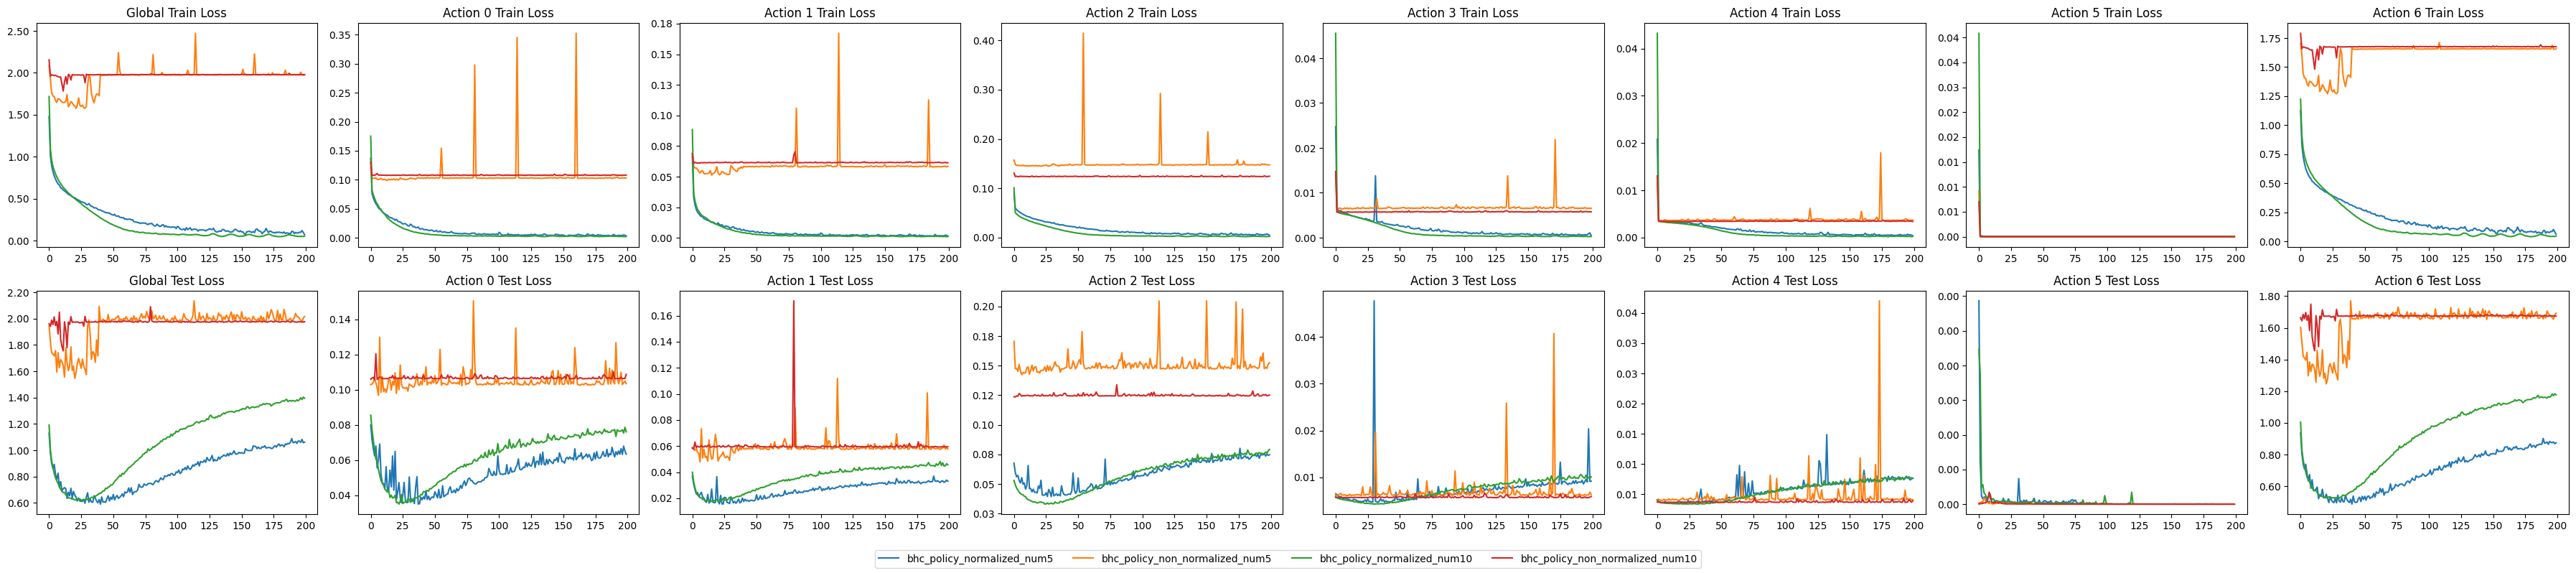

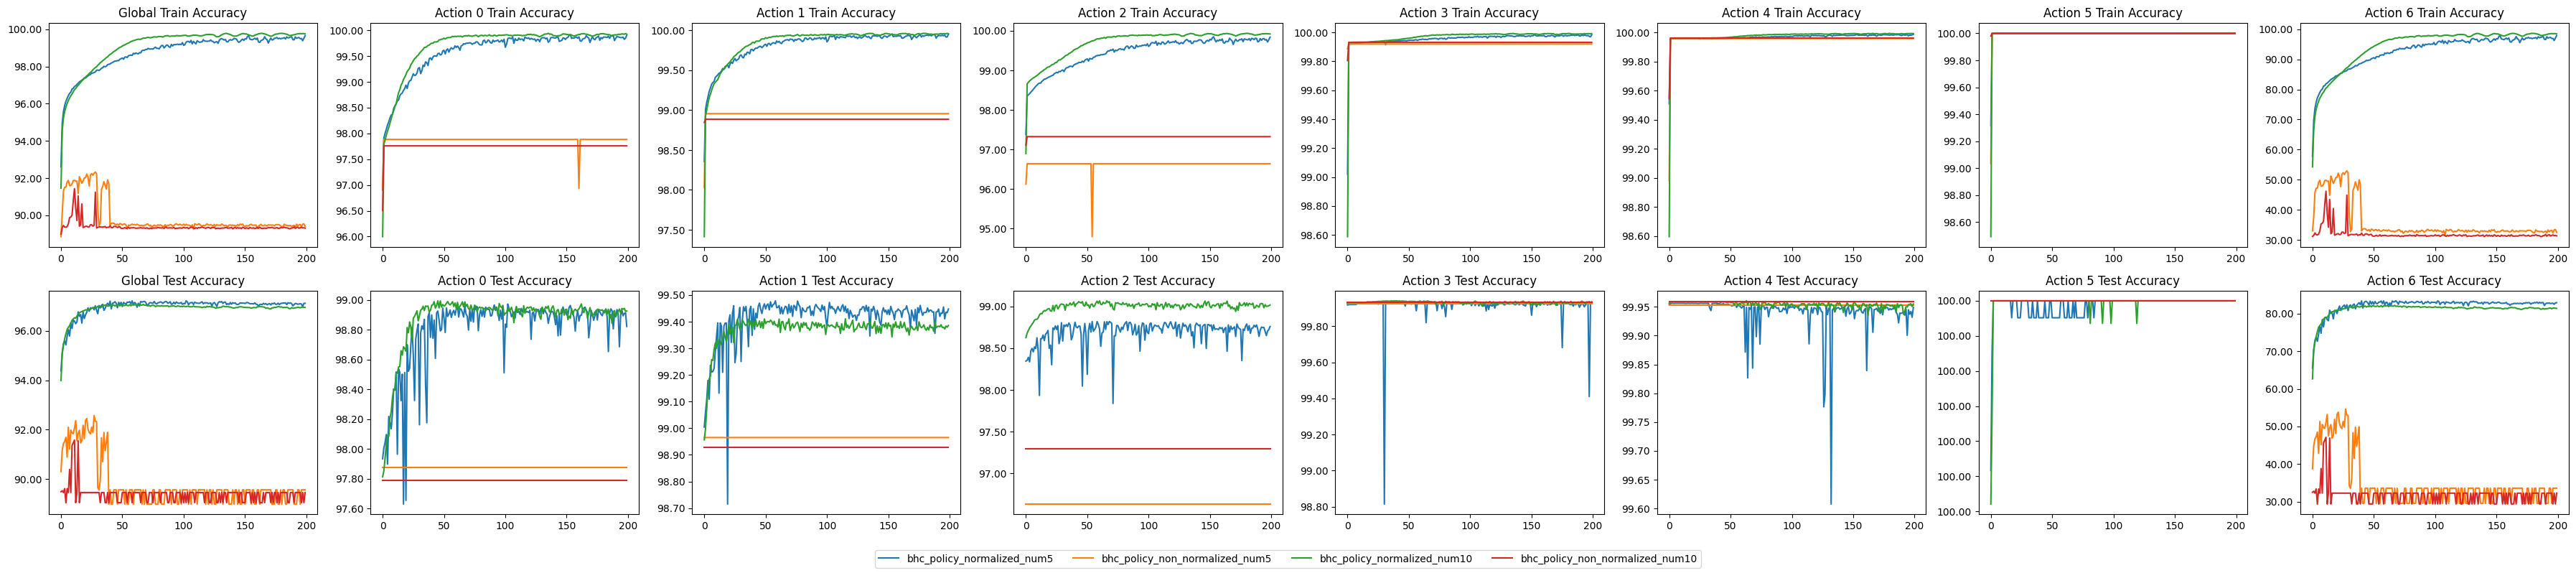

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import joblib

def plot_histories_1(histories, names, max_epochs=None):
    if max_epochs is None:
        max_epochs = len(histories[0]['train_loss'])

    epochs = range(max_epochs)

    # Plot Losses
    fig, axes = plt.subplots(2, 8, figsize=(36, 8))
    for ax in axes.flatten():
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

    for row, (metric, label) in enumerate(zip(['train_loss', 'test_loss'], ['Train Loss', 'Test Loss'])):
        axes[row, 0].set_title('Global ' + label)
        for history, name in zip(histories, names):
            axes[row, 0].plot(epochs, history[metric][:max_epochs], label=name)

        for i in range(len(histories[0]['train_loss_per_action'])):
            axes[row, i + 1].set_title(f'Action {i} {label}')
            for history, name in zip(histories, names):
                axes[row, i + 1].plot(epochs, history[f'{metric}_per_action'][i][:max_epochs])

    # Légende unique partagée
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(names))
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

    # Plot Accuracies
    fig, axes = plt.subplots(2, 8, figsize=(36, 8))
    for ax in axes.flatten():
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

    for row, (metric, label) in enumerate(zip(['train_accuracies', 'test_accuracies'], ['Train Accuracy', 'Test Accuracy'])):
        axes[row, 0].set_title('Global ' + label)
        for history, name in zip(histories, names):
            axes[row, 0].plot(epochs, [np.mean(acc) for acc in history[metric][:max_epochs]], label=name)

        for i in range(len(histories[0]['train_accuracies_per_action'])):
            axes[row, i + 1].set_title(f'Action {i} {label}')
            for history, name in zip(histories, names):
                axes[row, i + 1].plot(epochs, history[f'{metric}_per_action'][i][:max_epochs])

    # Légende unique partagée
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(names))
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


plot_histories_1(
    [
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num5/history'), 
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num5/history'),
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num10/history'),
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num10/history'),
    ], 
    ['bhc_policy_normalized_num5', 'bhc_policy_non_normalized_num5', 'bhc_policy_normalized_num10','bhc_policy_non_normalized_num10'],
    max_epochs=200,
)


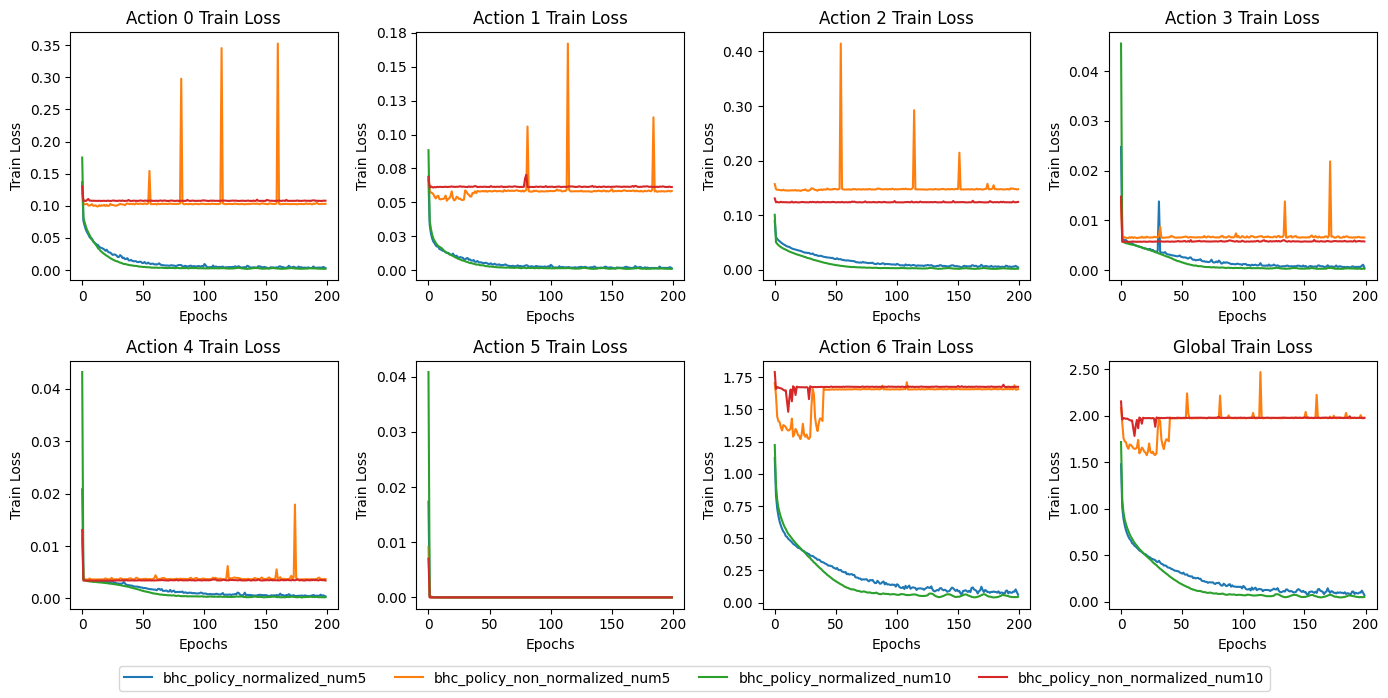

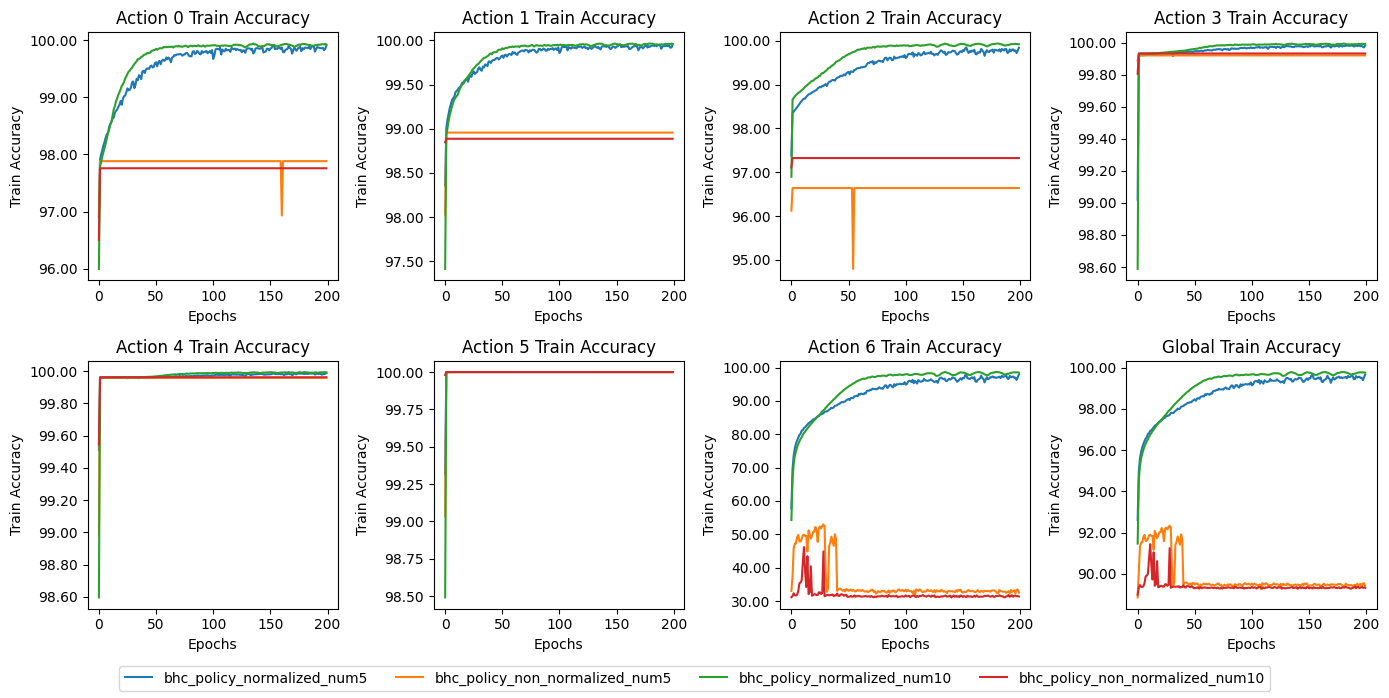

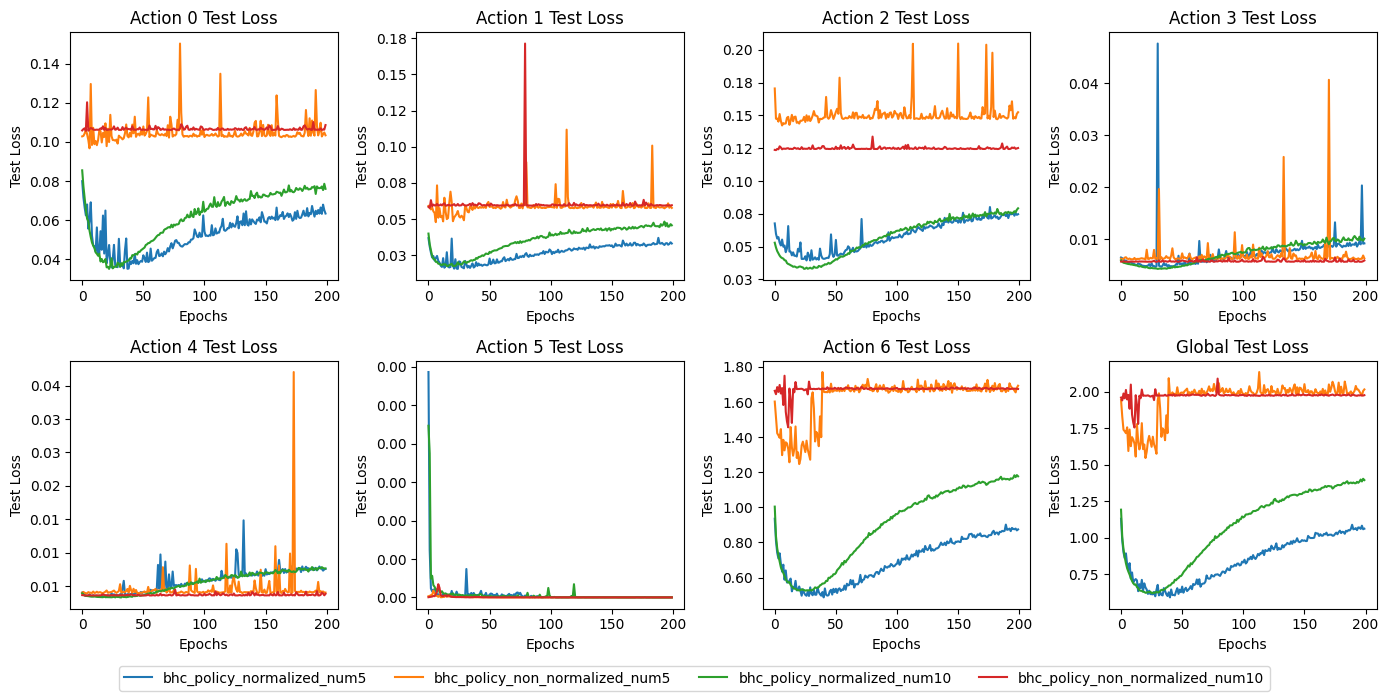

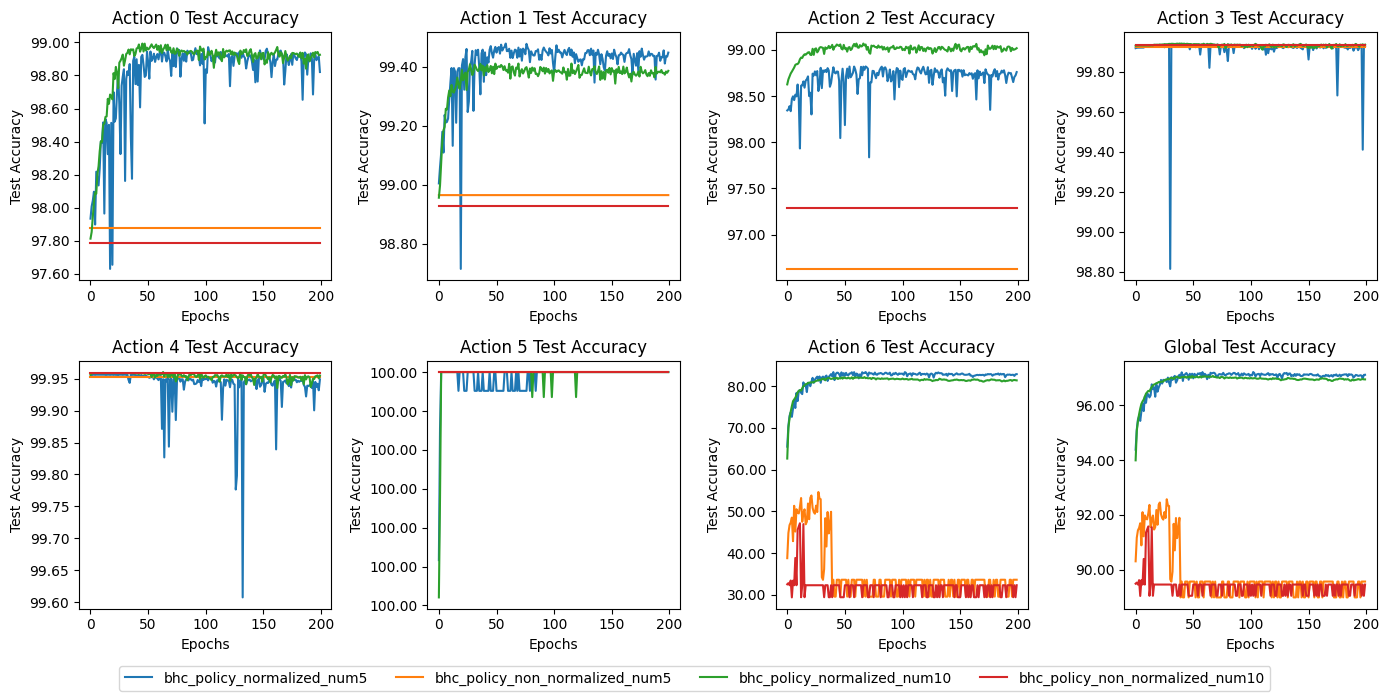

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
from matplotlib.ticker import FuncFormatter

def plot_histories(histories, names, max_epochs=None):
    if max_epochs is None:
        max_epochs = len(histories[0]['train_loss'])

    epochs = range(max_epochs)
    metrics = [
        ('train_loss', 'Train Loss'),
        ('train_accuracies', 'Train Accuracy'),
        ('test_loss', 'Test Loss'),
        ('test_accuracies', 'Test Accuracy')
    ]
    
    for metric, label in metrics:
        fig, axes = plt.subplots(2, 4, figsize=(14, 7))
        
        # Formatting axes
        for ax in axes.flatten():
            ax.get_yaxis().get_major_formatter().set_useOffset(False)
            ax.get_yaxis().get_major_formatter().set_scientific(False)
            ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
            ax.set_xlabel("Epochs")  # X-axis label for all subplots

        # Global metric plot
        axes[-1, -1].set_title(f'Global {label}')
        axes[-1, -1].set_ylabel(label)  # Y-axis label for the global plot
        for history, name in zip(histories, names):
            if 'accuracies' in metric:
                axes[-1, -1].plot(epochs, [np.mean(acc) for acc in history[metric][:max_epochs]], label=name)
            else:
                axes[-1, -1].plot(epochs, history[metric][:max_epochs], label=name)
        
        # Per-action metric plots
        num_actions = len(histories[0][f'{metric}_per_action'])
        for i in range(num_actions):
            row, col = divmod(i, 4)
            axes[row, col].set_title(f'Action {i} {label}')
            axes[row, col].set_ylabel(label)  # Y-axis label for individual action plots
            for history, name in zip(histories, names):
                axes[row, col].plot(epochs, history[f'{metric}_per_action'][i][:max_epochs])
        
        # Shared legend (remove duplicates)
        handles, labels = axes[-1, -1].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=len(names))
        
        fig.tight_layout(rect=[0, 0.04, 1, 1])
        plt.show()

plot_histories(
    [
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num5/history'),
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num5/history'),
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num10/history'),
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num10/history'),
    ],
    ['bhc_policy_normalized_num5', 'bhc_policy_non_normalized_num5', 'bhc_policy_normalized_num10', 'bhc_policy_non_normalized_num10'],
    max_epochs=200,
)


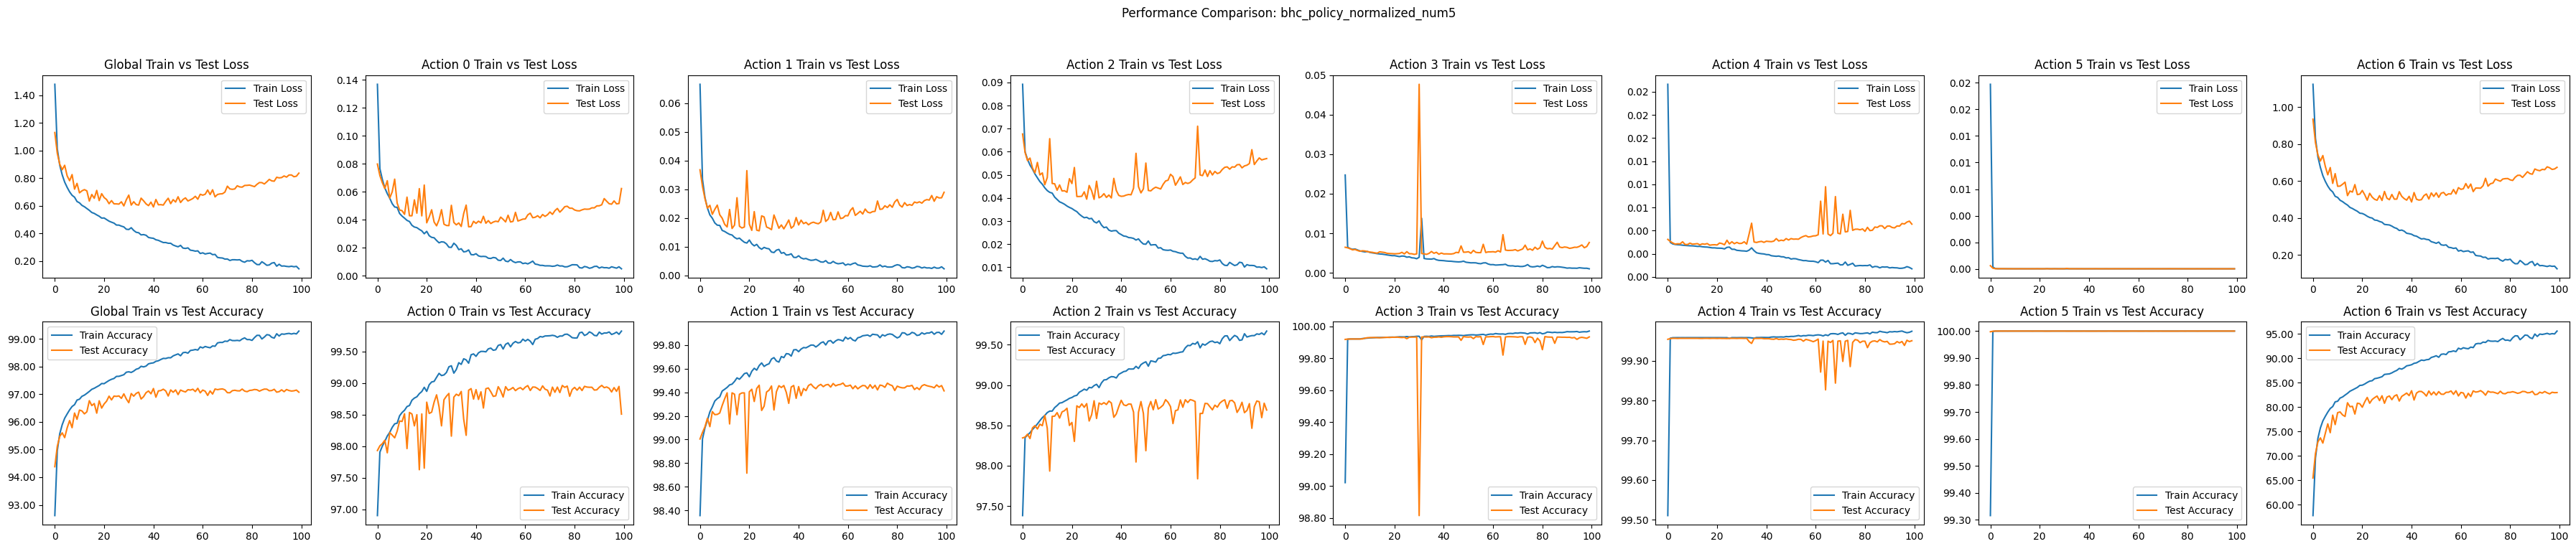

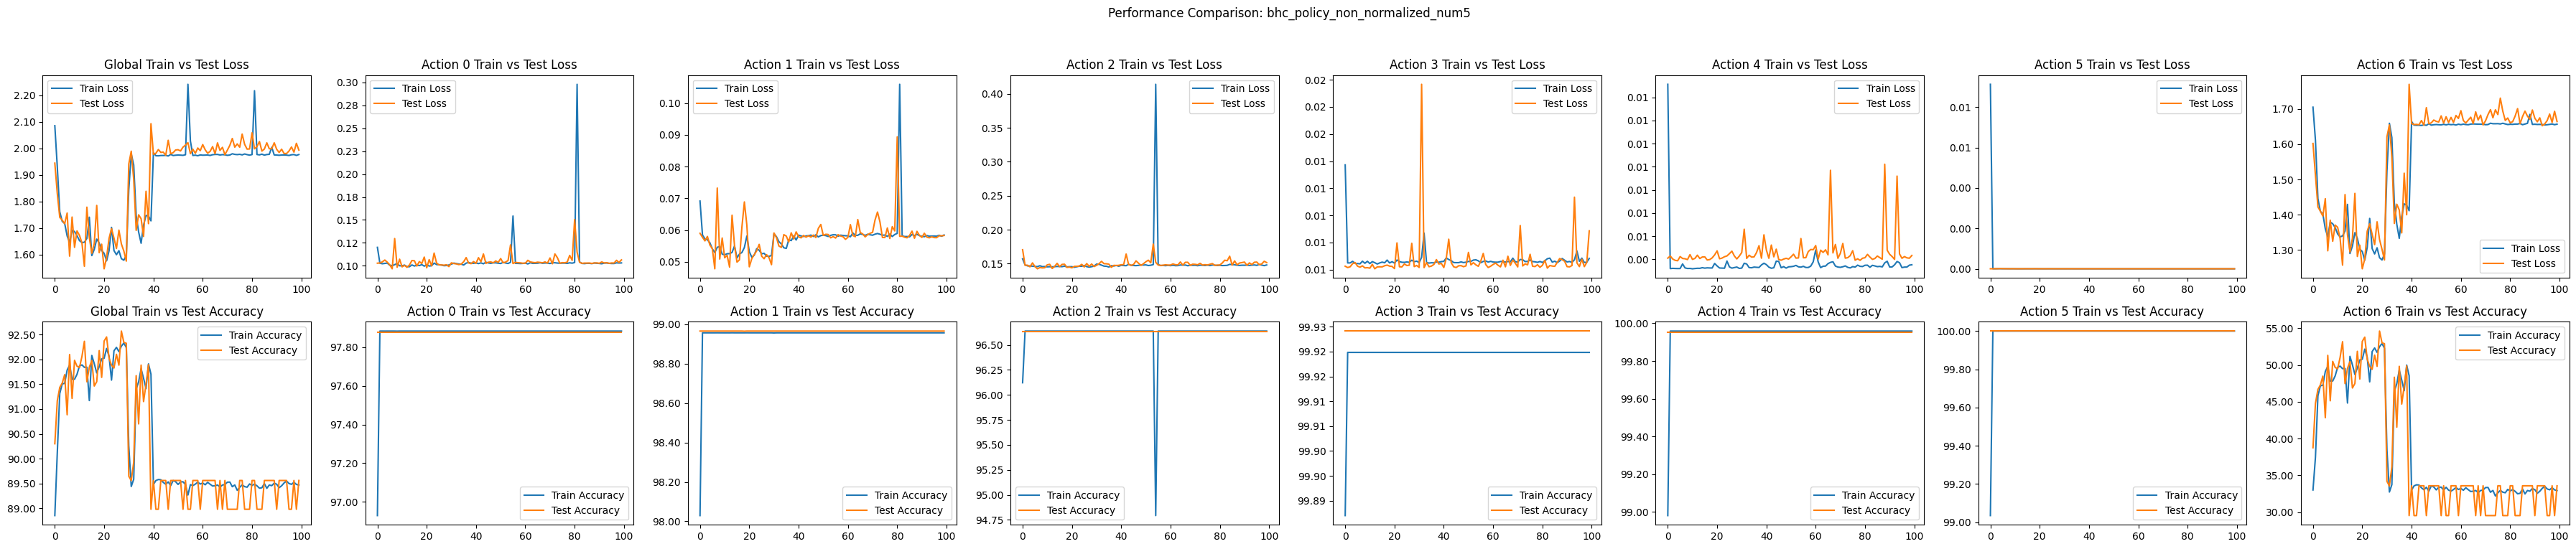

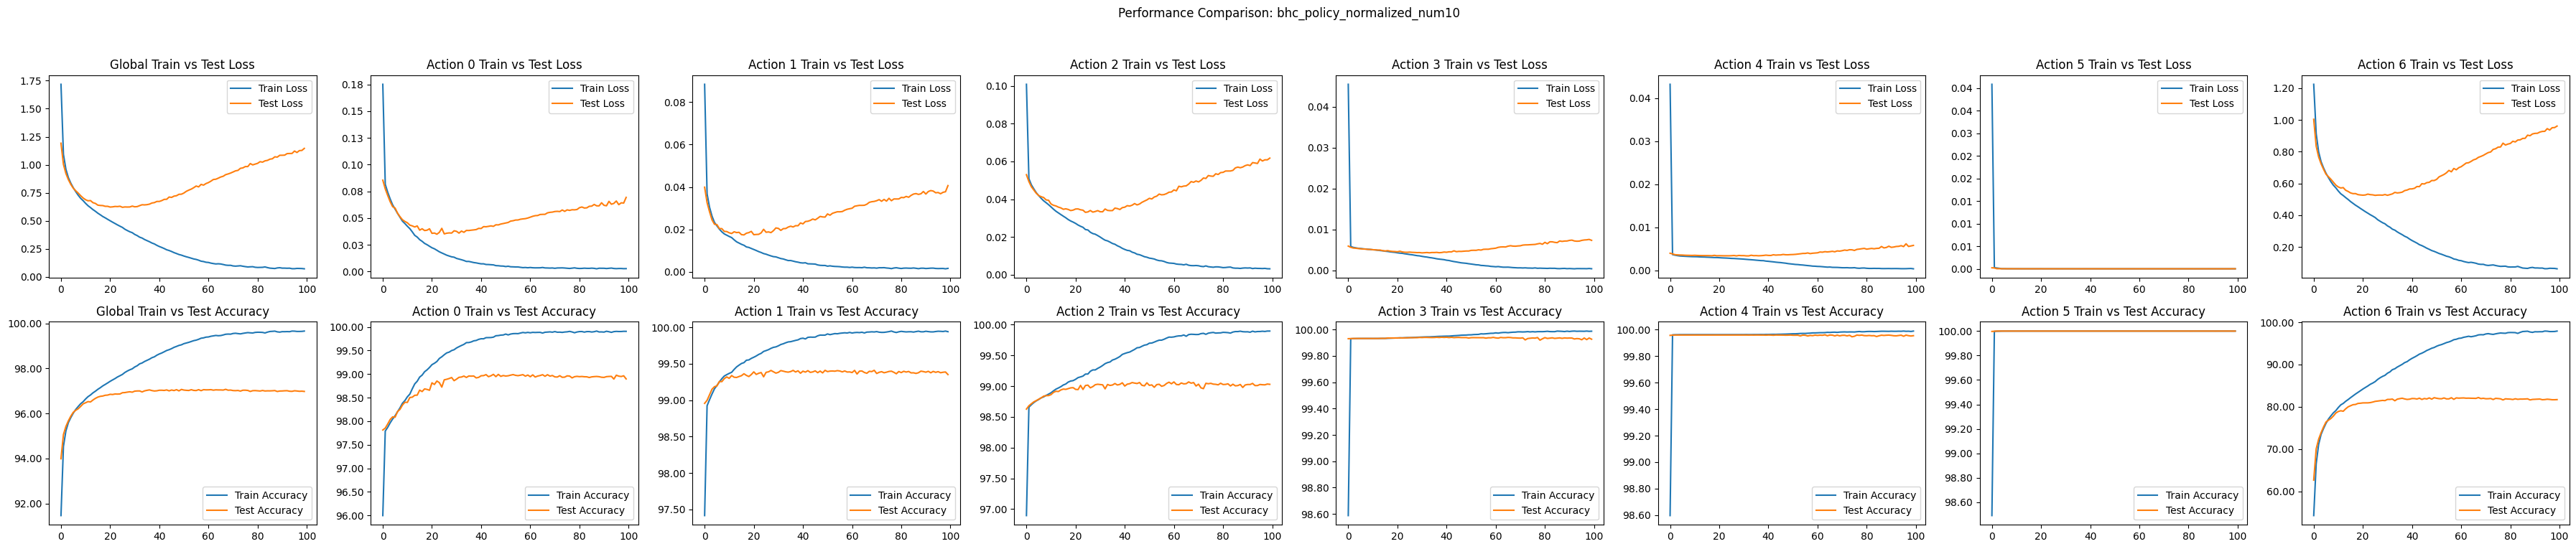

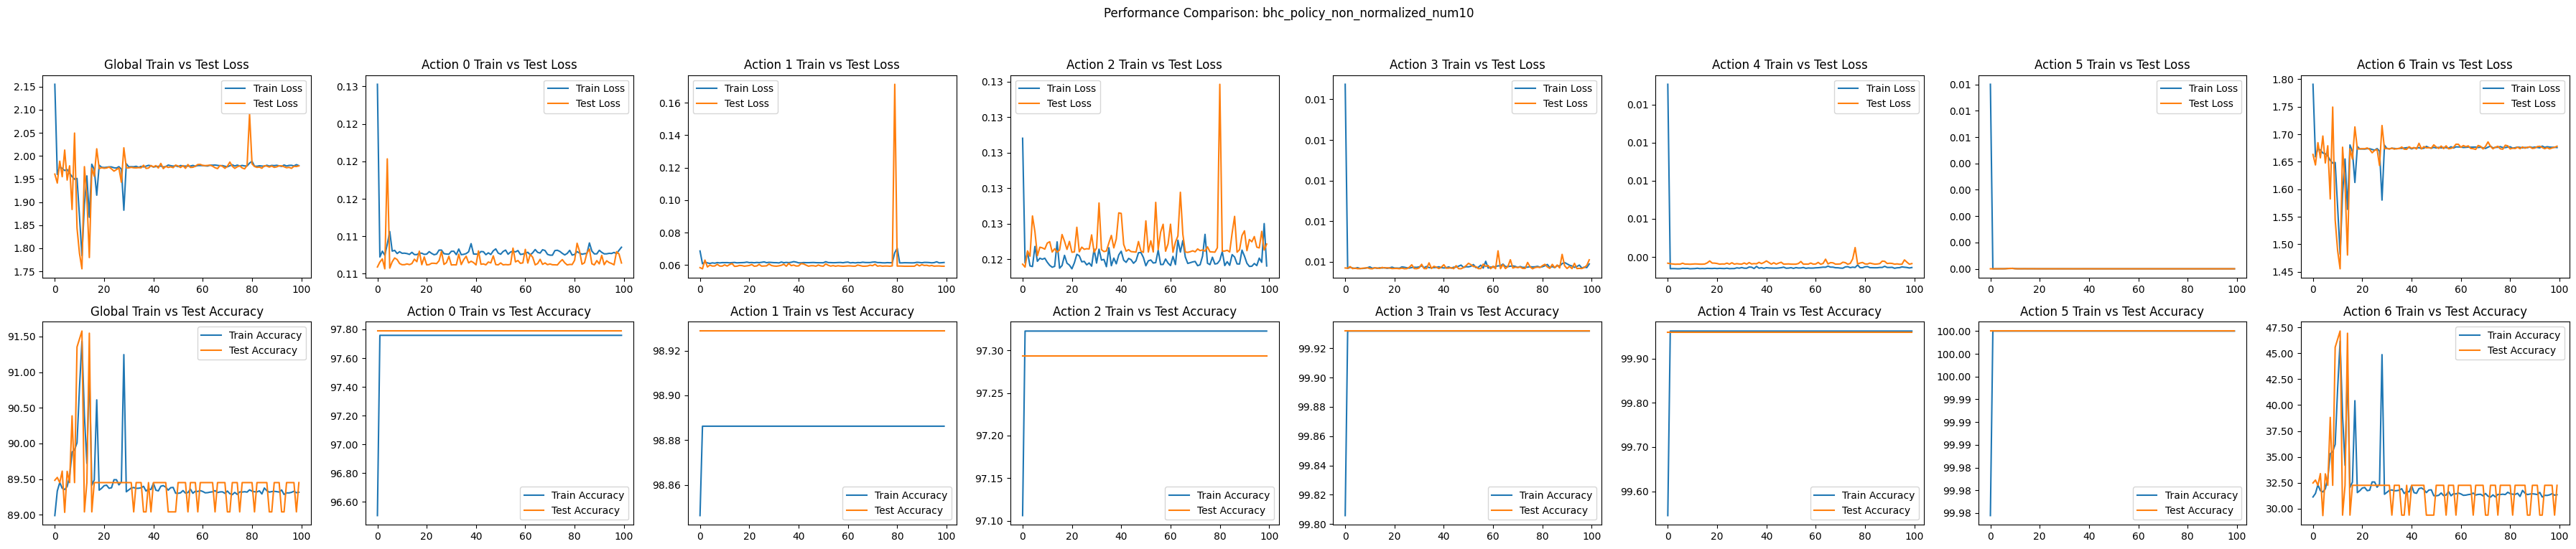

In [57]:
def plot_histories_2(histories, names, max_epochs=None):
    if max_epochs is None:
        max_epochs = len(histories[0]['train_loss'])

    epochs = range(max_epochs)
    
    for history, name in zip(histories, names):
        fig, axes = plt.subplots(2, 8, figsize=(36, 8))
        for ax in axes.flatten():
            ax.get_yaxis().get_major_formatter().set_useOffset(False)
            ax.get_yaxis().get_major_formatter().set_scientific(False)
            ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

        fig.suptitle(f"Performance Comparison: {name}")
        
        # Plot for Loss comparison (Train vs Test)
        axes[0, 0].set_title('Global Train vs Test Loss')
        axes[0, 0].plot(epochs, history['train_loss'][:max_epochs], label='Train Loss')
        axes[0, 0].plot(epochs, history['test_loss'][:max_epochs], label='Test Loss')
        axes[0, 0].legend()

        for i in range(len(history['train_loss_per_action'])):
            axes[0, i + 1].set_title(f'Action {i} Train vs Test Loss')
            axes[0, i + 1].plot(epochs, history['train_loss_per_action'][i][:max_epochs], label='Train Loss')
            axes[0, i + 1].plot(epochs, history['test_loss_per_action'][i][:max_epochs], label='Test Loss')
            axes[0, i + 1].legend()

        # Plot for Accuracy comparison (Train vs Test)
        axes[1, 0].set_title('Global Train vs Test Accuracy')
        axes[1, 0].plot(epochs, [np.mean(acc) for acc in history['train_accuracies'][:max_epochs]], label='Train Accuracy')
        axes[1, 0].plot(epochs, [np.mean(acc) for acc in history['test_accuracies'][:max_epochs]], label='Test Accuracy')
        axes[1, 0].legend()

        for i in range(len(history['train_accuracies_per_action'])):
            axes[1, i + 1].set_title(f'Action {i} Train vs Test Accuracy')
            axes[1, i + 1].plot(epochs, history['train_accuracies_per_action'][i][:max_epochs], label='Train Accuracy')
            axes[1, i + 1].plot(epochs, history['test_accuracies_per_action'][i][:max_epochs], label='Test Accuracy')
            axes[1, i + 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for suptitle
        plt.show()


plot_histories_2(
    [
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num5/history'), 
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num5/history'),
        joblib.load('stk_actor/trained_agents/normed_behavioral_cloning_num10/history'),
        joblib.load('stk_actor/trained_agents/non_normed_behavioral_cloning_num10/history'),
    ],
    ['bhc_policy_normalized_num5', 'bhc_policy_non_normalized_num5', 'bhc_policy_normalized_num10','bhc_policy_non_normalized_num10'],
    max_epochs=100,
)


In [18]:
# torch.save(policy.state_dict(),'policy_normed_1024_1024_1024_Tanh_statedict_2')
# torch.save(mean,'buffer_mean_2')
# torch.save(std,'buffer_std_2')